# Longitudinal Analysis

## Imports and initialize WebScrapper object

In [36]:
import nltk

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag

from collections import defaultdict

from scipy.spatial.distance import cosine

from WebScrapping import WebScrapper

from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_non_alphanum, strip_numeric, strip_short
from gensim.utils import tokenize

# Define plot style
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

### Web Scrapping

#### Create Web Scrapper Object

In [2]:
search_words = ["machine", "learning", "enthalpy"]

wspr = WebScrapper(search_words)

#### Web Scrapping on Springer and PubMed

In [ ]:
num_articles = 50

wspr.fetchArticles(max_articles=num_articles)

for article in wspr.articles:
    print(article)

#### Fetch articles components from SemanticScholar

In [5]:
num_articles = 10

wspr.fetchSemanticScholar(max_articles=num_articles) # Collects 20 articles components per minute

max_articles = 10
10 articles added


#### Save fetched article components to a Microsoft Excel file

In [ ]:
wspr.save_to_excel("fetched_articles_all_info.xlsx")

### Preprocess abstracts

#### Read Data

In [6]:
# In case the kernel was restarted read the saved Microsoft Excel file with the articles components
search_words = ["machine", "learning", "enthalpy"]

wspr = WebScrapper(search_words)

num_articles = wspr.read_from_Excel("fetched_articles_all_info.xlsx")

print(num_articles)

981


#### Basic preprocessing techniques applied

##### Auxiliary functions

In [8]:
nltk.download("wordnet")
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')


def get_all_words(tokenized_abstracts):
    """
    Return the total number of words across all abstracts
    """
    words = []
    for abstract in tokenized_abstracts:
        for word in abstract:
            if word not in words:
                words.append(word)

    return sorted(words)


def removeNonImportantWords(abstracts):
    """
    Remove words that only appear one or two times in all abstracts
    """
    words = defaultdict(int)

    for abstract in abstracts:
        for word in abstract:
            words[word] += 1

    # self.n_words = len(list(words.keys()))

    important_words = [[word for word in abstract if words[word] > 2] for abstract in abstracts]
    return important_words


def get_wordnet_pos(tag):
    """
    Return the categorized word based on the part-of-Speech tag
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize_text(tokenized_text):
    """
    Return the tokenized corpus lemmatized
    """
    wnl = WordNetLemmatizer()

    # Get Pos Tagged
    ptag = pos_tag(tokenized_text)

    return [wnl.lemmatize(pt[0], get_wordnet_pos(pt[1])) for pt in ptag]


def stem_text(tokenized_text):
    """
    Return the tokenized corpus stemmatized
    """
    ps = PorterStemmer()
    return [ps.stem(token) for token in tokenized_text]


def normalize_text(tokenized_text, type="Lemm"):
    if type=="Lemm":
        return lemmatize_text(tokenized_text)
    elif type=="Stemm":
        return stem_text(tokenized_text)
    else:
        return tokenized_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rodd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rodd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rodd\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### PreProcesing

In [9]:
# List to save the processed abstracts
processed_abstracts = []

for article in wspr.articles:

    # Lower case the words of the abstract
    abstract = article.abstract.lower()

    # Remove the punctuation of the abstract, remove the numeric values, remove the alphanumeric
    # values, remove the short words (with one or two letters) and remove stop words
    abstract = remove_stopwords(strip_short(strip_non_alphanum(strip_numeric(strip_punctuation(abstract))), minsize=3))
    
    # Tokenize abstract
    tokenized_abstract = list(tokenize(abstract))

    # Add the processed abstract to the list
    processed_abstracts.append(tokenized_abstract)

# Filter abstract to remove uninportant words
filtered_abstracts = removeNonImportantWords(processed_abstracts)

# Normalize the abstracts a.k.a. Lemmatize or Stemmatize
normalized_abstracts = [normalize_text(tokenized_abstract, "Lemm") for tokenized_abstract in filtered_abstracts]

# Get list with all words
all_words = get_all_words(normalized_abstracts)

#### Calculate tf-idf

In [72]:
# Calculate word countings
joint_abstracts = []
for abstract in normalized_abstracts:
    joint_abstracts.append(" ".join(abstract))

CV = CountVectorizer()
countings = CV.fit_transform(joint_abstracts)

# Calculate tfidf matrix
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_matrix = tfidf_transformer.fit_transform(countings)

(982, 3733)


### Reduce dimensionality of tf-idf matrix using Truncated SVD

#### Find the optimal number of components using the explained variance

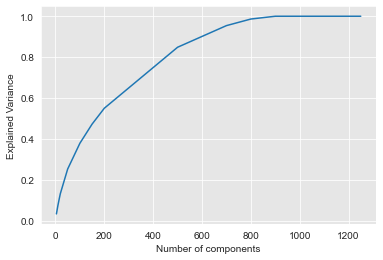

In [12]:
n_comp = [4,10,15,20,50,100,150,200,500,700,800,900,1000,1250] 
explained_var_ratio = [] 
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(tfidf_matrix)
    explained_var_ratio.append(svd.explained_variance_ratio_.sum())
    
plt.plot(n_comp, explained_var_ratio)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.show()

#### Calculate an aproximation of the tf-idf matrix with Truncated SVD with n_components=800

In [13]:
# Applying SVD method to reduce dimensionality and then normalize
svd = TruncatedSVD(n_components=800)

# L2 Norm normalization
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

M_hat = lsa.fit_transform(tfidf_matrix)

### Clustering with K-means

#### Finding the optimal number of clusters using the Elbow method

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


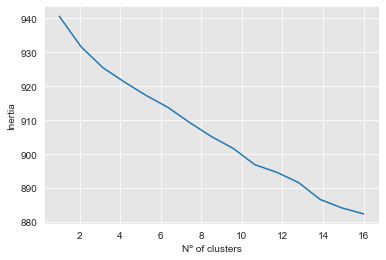

In [14]:
# Elbow Method with inertia
inertia_values = []
for i in range(1, 16):
    kmeans = KMeans(init="k-means++", n_clusters=i)
    kmeans.fit(M_hat)

    inertia_values.append(kmeans.inertia_)

num_clusters = np.linspace(1,16,15).T

plt.plot(num_clusters, inertia_values)
plt.xlabel("Nº of clusters")
plt.ylabel("Inertia")
plt.show()

#### Apply the K-means algorithm to n_clusters=8

In [15]:
# Perform k-means algorithm for number of clusters = 8
n_clusters = 8

final_kmeans = KMeans(init="k-means++", n_clusters=n_clusters, max_iter=600, tol=1e-6, algorithm="full")
final_kmeans.fit(M_hat)

# Convert back the centroids
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = CV.get_feature_names()

for i in range(0,n_clusters):
    print("Cluster {}: {}, {}, {}, {}, {}\n".format(i, terms[order_centroids[i, 0]], terms[order_centroids[i, 1]], terms[order_centroids[i, 2]], terms[order_centroids[i, 3]], terms[order_centroids[i, 4]]))

article_labels = final_kmeans.labels_

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Cluster 0: feature, classifier, learn, selection, program

Cluster 1: matrix, approximation, covariance, ridge, expect

Cluster 2: learn, data, image, machine, task

Cluster 3: kernel, elm, learn, function, weight

Cluster 4: enthalpy, material, structure, model, thermodynamic

Cluster 5: time, series, classifier, feature, data

Cluster 6: similarity, kannada, language, refinement, tagger

Cluster 7: translation, rank, preference, sentence, feature



### Reduce dimensionality of tf-idf matrix using Non-negative Matrix Factorization

#### Auxiliary function

In [16]:
def get_n_maximum(nums, n):
    """
    Return the n maximum values of a list
    """
    indexes = []
    values = []

    for i in range(n):
        max = nums[0]
        index = 0
        for k in range(1, nums.shape[0]):
            num = nums[k]
            if max < num and k not in indexes:
                max = num
                index = k
        
        values.append(max)
        indexes.append(index)

    return (indexes, values)

#### Applying the NMF algorithm to the tf-idf matrix

In [17]:
# Applying NMF method to reduce dimensionality
n_components = 16
nmf = NMF(n_components=n_components, init='random', random_state=32)

W = nmf.fit_transform(tfidf_matrix)
H = nmf.components_

# Initialize dictionary with topics and top words
topics = {}
for i in range(n_components):
    topics[i] = []

# Get each topic's top words
terms = CV.get_feature_names()
for topic in range(n_components):
    words = H[topic, :]
    indexes = get_n_maximum(words, 5)[0]

    for l, ind in enumerate(indexes):
        topics[topic].append(terms[ind])

print(topics)

docs = {}
# Topic of each document
for doc_num in range(W.shape[0]):
    doc = W[doc_num,:]
    doc_topic = get_n_maximum(doc, 1)[0]

    docs[doc_num] = doc_topic[0]

{0: ['data', 'learn', 'machine', 'application', 'system'], 1: ['knowledge', 'task', 'discovery', 'csmtl', 'domain'], 2: ['sensor', 'colorimetric', 'explosive', 'classifier', 'decision'], 3: ['series', 'time', 'classifier', 'feature', 'discrete'], 4: ['image', 'deep', 'network', 'medical', 'classification'], 5: ['outlier', 'method', 'detection', 'kdd', 'lof'], 6: ['bias', 'stability', 'factor', 'predictive', 'repeatability'], 7: ['similarity', 'graph', 'refinement', 'instance', 'measure'], 8: ['regression', 'model', 'cmars', 'parameter', 'procedure'], 9: ['energy', 'material', 'property', 'molecule', 'enthalpy'], 10: ['policy', 'reinforcement', 'iteration', 'scheme', 'arm'], 11: ['feature', 'translation', 'sentence', 'smt', 'look'], 12: ['svm', 'kernel', 'vector', 'support', 'algorithm'], 13: ['matrix', 'approximation', 'ridge', 'expect', 'covariance'], 14: ['kannada', 'language', 'kluster', 'formalism', 'representation'], 15: ['model', 'naïve', 'bayes', 'hierarchical', 'interaction']}


D:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


### Find the similar articles in the topic 9

In [75]:
# Get all articles from topic 9

topic_articles_NMF = []
topic_articles = []
topic_articles_tfidf = []

for i in range(0, num_articles): 
    if docs[i] == 9:
        topic_articles_NMF.append(W[i,:])
        topic_articles_tfidf.append(tfidf_matrix[i,:])
        topic_articles.append(i)
        
print(len(topic_articles_tfidf))
# The main article used as reference is in the first position on topic 9
reference_article = topic_articles_NMF[0]

num_topic9_articles = len(topic_articles)
print(num_topic9_articles)

# Get Cosine similarity matrix for 
cosine_sim = np.zeros((num_topic9_articles, num_topic9_articles))

for i, article1_nmf in enumerate(topic_articles_NMF):
    for j, article2_nmf in enumerate(topic_articles_NMF):
        cosine_sim[i,j] = 1 - cosine(article1_nmf, article2_nmf)

print(cosine_sim.shape)

cosine_sim_norm = normalizer.fit_transform(cosine_sim)


120
120
(120, 120)


#### Apply K-means algorithm

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


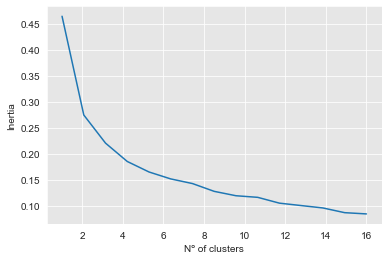

In [76]:
# Elbow Method with inertia
inertia_values = []
for i in range(1, 16):
    kmeans = KMeans(init="k-means++", n_clusters=i)
    kmeans.fit(cosine_sim)

    inertia_values.append(kmeans.inertia_)

num_clusters = np.linspace(1,16,15).T

plt.plot(num_clusters, inertia_values)
plt.xlabel("Nº of clusters")
plt.ylabel("Inertia")
plt.show()

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


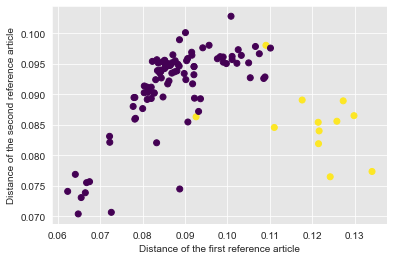

1
0
[1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0]
0.13405398022723997
0.10083445002629976
0.07733571287618088
0.10281367253016288


In [100]:
# Perform k-means algorithm for number of clusters = 2
n_clusters = 2

final_kmeans = KMeans(init="k-means++", n_clusters=n_clusters, max_iter=600, tol=1e-6, algorithm="full")
final_kmeans.fit(cosine_sim_norm)

y_kmeans = final_kmeans.predict(cosine_sim)

plt.scatter(cosine_sim_norm[0,:], cosine_sim_norm[38,:], c=y_kmeans, cmap="viridis")
plt.xlabel("Distance of the first reference article")
plt.ylabel("Distance of the second reference article")
plt.show()

In [ ]:
relevant_article = []

c = 0
for i, article_label in enumerate(y_kmeans):
    if article_label == 0:
        c += 1
        relevant_article.append(i)

print("count={}".format(c))

data = []
for i in relevant_article:
    data.append([wspr.articles[i].title, wspr.articles[i].abstract, wspr.articles[i].publish_year, wspr.articles[i].url, wspr.articles[i].referenceCount, wspr.articles[i].citationCount, wspr.articles[i].influentialCitationCount, docs[i]])

df = pd.DataFrame(data)
df.to_excel(excel_writer="topic_9_relevant_articles.xlsx", sheet_name="Articles", header=["Title", "Abstract", "Publish Year", "URL", "referenceCount", "citationCount", "influentialCitationCount", "Topic"])    


### Save articles to an excel file according to each cluster

In [19]:
data = []
for i in range(0, num_articles):
    data.append([wspr.articles[i].title, wspr.articles[i].abstract, wspr.articles[i].publish_year, wspr.articles[i].url, wspr.articles[i].referenceCount, wspr.articles[i].citationCount, wspr.articles[i].influentialCitationCount, docs[i]])

df = pd.DataFrame(data)
df.to_excel(excel_writer="articles_by_cluster_all_info_v3.xlsx", sheet_name="Articles", header=["Title", "Abstract", "Publish Year", "URL", "referenceCount", "citationCount", "influentialCitationCount", "Topic"])    
